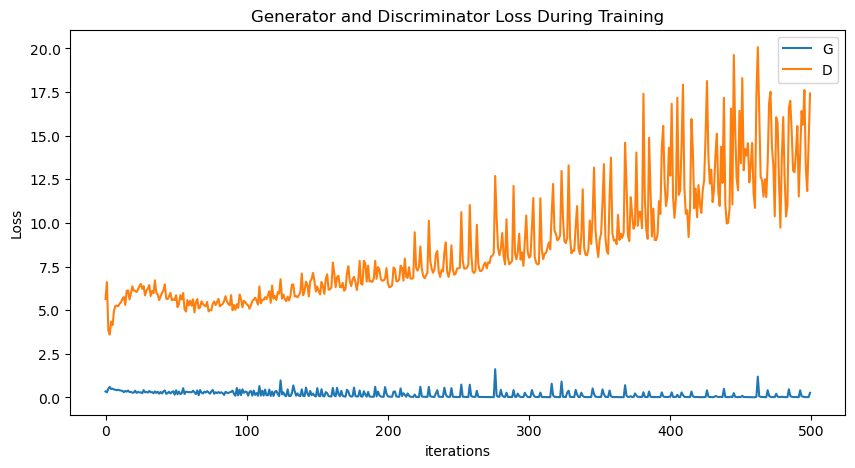

In [66]:
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model_butterfly_final.pth')

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

![alt text](image.png)

In [73]:
params = {
    'dim_z' : 100,
    'num_epochs' : 500,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':2,
    'k_g':1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(params).to(device)
netD = Discriminator().to(device)

# Load the model checkpoint
checkpoint = torch.load('model_butterfly_epoch_300.pth', map_location=device)

netG.load_state_dict(checkpoint['generator'])
netD.load_state_dict(checkpoint['discriminator'])

netG = netG.to(device)
netD = netD.to(device)

netG.eval()
fid_value = calculate_fid_butterfly(netG,params)
print(f"FID Score : {fid_value}")

100%|██████████| 17/17 [00:02<00:00,  5.81it/s]


FID Score : 178.20849547639762


FID Score: 178.20
Even with increasing epochs, FID was increasing and image quality was also decreasing.
Changing Discriminator to Generator Training ratio has decreased FID score , and also increased quality of generated images


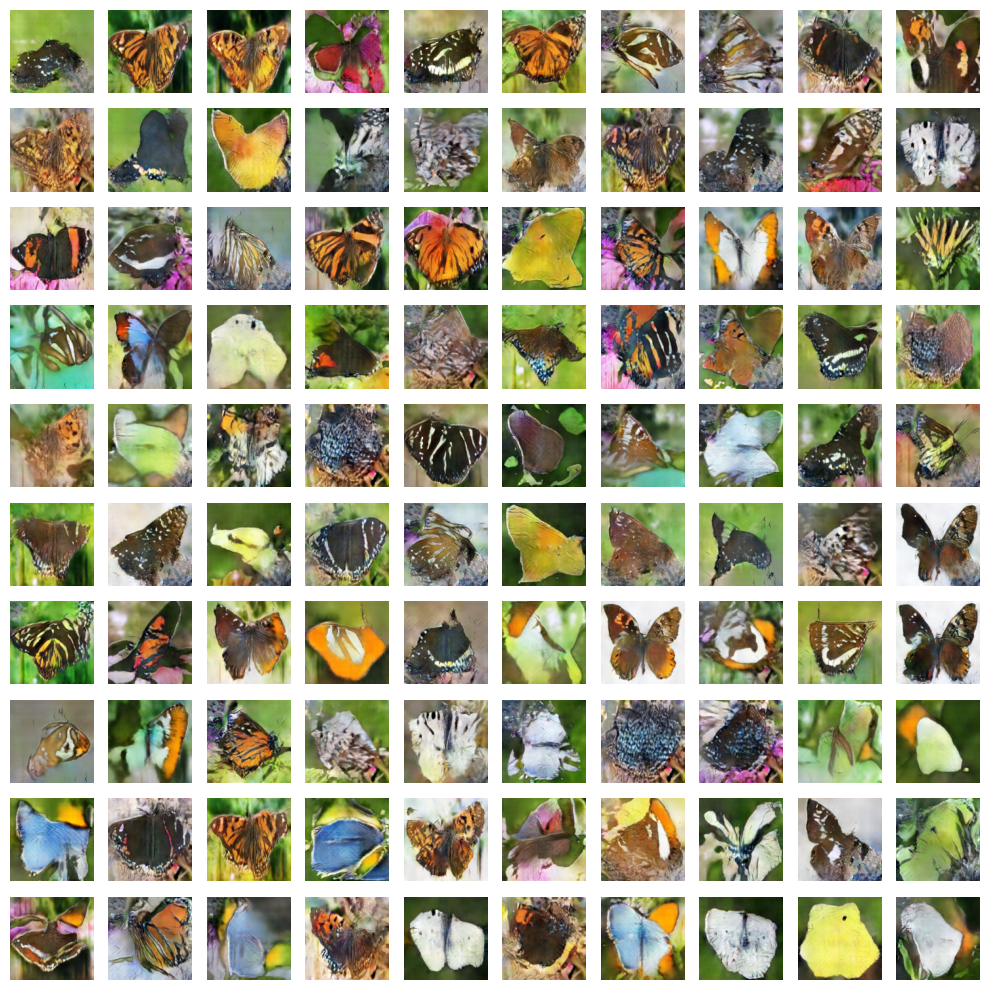

In [94]:
z = torch.randn(100, params['dim_z'], 1, 1, device=device)
with torch.no_grad():
    generated_img = netG(z).detach().cpu()

fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
        min_val = img.min()
        max_val = img.max()
        normalized_img = (img - min_val) / (max_val - min_val)
                
        # Plot the image
        axs[i, j].imshow(normalized_img)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

#### Generated Images

![alt text](image-1.png)

#### Training Discriminator and Generator in 3:2 ratio

In [ ]:


# HyperParameters
params = {
    'dim_z' : 100,
    'num_epochs' : 500,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':3,
    'k_g':2}

# Plot the training images.
data = next(iter(dataloader_butterfly))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    data['image'].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

# Generator
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

# Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Loss function.
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(0.5, 0.999))

G_losses = []
D_losses = []


In [ ]:
for epoch in range(params['num_epochs']):

    errorGs=[]
    errorDs=[]
    for i, data in enumerate(dataloader_butterfly):
        errorD_k=[]
        for k in range(params['k_d']):
            real_image = data['image'].to(device)
            batch_size = real_image.size(0)
            netD.zero_grad()
            label = torch.full((batch_size, ), 1, device=device).float()
            output = netD(real_image).view(-1)
            errorD_real = criterion(output, label)
            errorD_real.backward()
            z = torch.randn(batch_size, params['dim_z'], 1, 1, device=device)
            fake_data = netG(z)
            label.fill_(0)
            output = netD(fake_data.detach()).view(-1)
            errorD_fake = criterion(output, label)
            errorD_fake.backward()
            errorD = errorD_real + errorD_fake
            optimizerD.step()
            errorD_k.append(errorD.item())
        errorD_k_avg=np.average(errorD_k)
        errorDs.append(errorD_k_avg)
        
        errorG_k=[]
        for k in range(params['k_g']): 
            netG.zero_grad()
            label.fill_(1)
            output = netD(fake_data).view(-1)
            errorG = criterion(output, label)
            errorG.backward()
            optimizerG.step()
            errorG_k.append(errorG.item())

        errorG_k_avg=np.average(errorG_k)
        errorGs.append(errorG_k_avg)

    # Save the losses for plotting.
    G_losses.append(np.average(errorDs))
    D_losses.append(np.average(errorGs))

    # Save the model.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model_butterfly_epoch_{}.pth'.format(epoch+1))
    
    
    if (epoch+1) % 100 == 0: 
        netG.eval()
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, params['num_epochs'], errorD.item(), errorG.item()))  
         
        z = torch.randn(100, params['dim_z'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(z).detach().cpu()

        fig, axs = plt.subplots(10, 10, figsize=(10, 10))

        for i in range(10):
            for j in range(10):
                img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val)
                
                # Plot the image
                axs[i, j].imshow(normalized_img)
                axs[i, j].axis('off')

        plt.tight_layout()
        plt.show()
        
        fid_value = calculate_fid_butterfly(netG,params)
        print(f"FID Score at epoch {epoch+1}: {fid_value}")


In [ ]:
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model_butterfly_final.pth')

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
params = {
    'dim_z' : 100,
    'num_epochs' : 500,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':2,
    'k_g':1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(params).to(device)
netD = Discriminator().to(device)

# Load the model checkpoint
checkpoint = torch.load('model_butterfly_epoch_300.pth', map_location=device)

netG.load_state_dict(checkpoint['generator'])
netD.load_state_dict(checkpoint['discriminator'])

netG = netG.to(device)
netD = netD.to(device)

netG.eval()
fid_value = calculate_fid_butterfly(netG,params)
print(f"FID Score : {fid_value}")

In [ ]:
z = torch.randn(100, params['dim_z'], 1, 1, device=device)
with torch.no_grad():
    generated_img = netG(z).detach().cpu()

fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
        min_val = img.min()
        max_val = img.max()
        normalized_img = (img - min_val) / (max_val - min_val)
                
        # Plot the image
        axs[i, j].imshow(normalized_img)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Animals Dataset

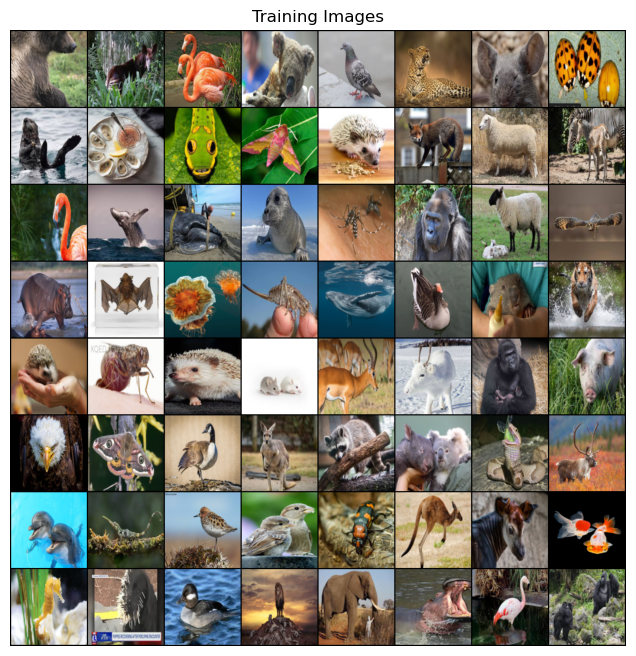

Generator(
  (conv_transpose1): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [95]:


# HyperParameters
params = {
    'dim_z' : 100,
    'num_epochs' : 300,
    'lr' : 0.0002,
    'save_epoch' : 10,
    'k_d':1,
    'k_g':1}

# Plot the training images.
data = next(iter(dataloader_animals))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    data[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

# Generator
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

# Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Loss function.
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(0.5, 0.999))

G_losses = []
D_losses = []
